In [1]:
#ref : https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')

Using TensorFlow backend.


In [2]:
import os
os.getcwd()

'D:\\workspace\\git\\Python_Practice'

In [3]:
os.chdir("D:\\workspace\\git\\Kaggle\\Digit-Recognizer")
os.getcwd()

'D:\\workspace\\git\\Kaggle\\Digit-Recognizer'

In [4]:
train = pd.read_csv("input/train.csv")
test = pd.read_csv("input/test.csv")

In [5]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


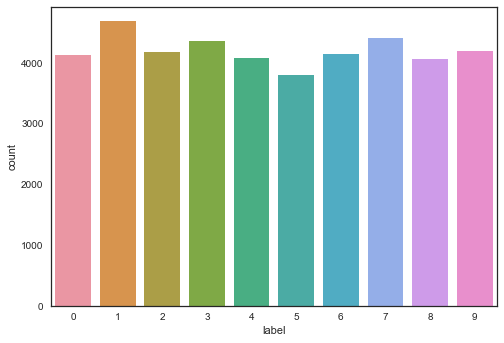

In [6]:
Y_train = train["label"]
X_train = train.drop('label', axis = 1) 

# free some space
del train

g = sns.countplot(Y_train)
#Y_train.value_counts()

In [7]:
X_train.shape

(42000, 784)

In [8]:
#pd.Series(~np.array(X_train.isnull().any())).describe()
#pd.Series([True, False]).describe()
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [9]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [10]:
# Normalize the data
X_train = X_train / 255.0
test = test / 255.0

In [11]:
X_train.shape[1]**0.5

28.0

In [12]:
#https://stackoverflow.com/questions/18691084/what-does-1-mean-in-numpy-reshape
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

#Keras requires an extra dimension in the end which correspond to channels. 
#MNIST images are gray scaled so it use only one channel. 
#For RGB images, there is 3 channels, we would have reshaped 784px vectors to 28x28x3 3D matrices.

In [13]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 10)

In [14]:
# Set the random seed
random_seed = 1111

In [15]:
sklearn.__version__

'0.18.1'

In [16]:
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)#, stratify = True)

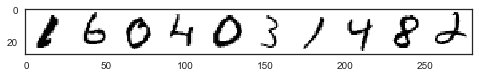

In [17]:
images =[X_train[i][:,:,0] for i in [j for j in range(0,10)]]# [X_train[0][:,:,0], X_train[1:6][:,:,0]]
#for ima in images:
#   plt.figure()
#  plt.imshow(ima)

plot_image = np.concatenate((images), axis=1)
plt.imshow(plot_image)

In [18]:
# Set the CNN model 
# CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [19]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [20]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [21]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [22]:
#https://stats.stackexchange.com/questions/153531/what-is-batch-size-in-neural-network
epochs = 50#30
batch_size = 100#86

In [23]:
# With data augmentation to prevent overfitting (accuracy 0.99286)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [24]:
# Fit the model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/50
603s - loss: 0.4627 - acc: 0.8512 - val_loss: 0.0644 - val_acc: 0.9810
Epoch 2/50
606s - loss: 0.1576 - acc: 0.9526 - val_loss: 0.0377 - val_acc: 0.9871
Epoch 3/50
603s - loss: 0.1172 - acc: 0.9656 - val_loss: 0.0322 - val_acc: 0.9907
Epoch 4/50
628s - loss: 0.1024 - acc: 0.9700 - val_loss: 0.0330 - val_acc: 0.9893
Epoch 5/50
600s - loss: 0.0905 - acc: 0.9751 - val_loss: 0.0345 - val_acc: 0.9893
Epoch 6/50
602s - loss: 0.0833 - acc: 0.9754 - val_loss: 0.0287 - val_acc: 0.9905
Epoch 7/50

Epoch 00006: reducing learning rate to 0.0005000000237487257.
599s - loss: 0.0810 - acc: 0.9773 - val_loss: 0.0419 - val_acc: 0.9886
Epoch 8/50
602s - loss: 0.0619 - acc: 0.9826 - val_loss: 0.0266 - val_acc: 0.9914
Epoch 9/50
604s - loss: 0.0604 - acc: 0.9827 - val_loss: 0.0220 - val_acc: 0.9924
Epoch 10/50
628s - loss: 0.0589 - acc: 0.9830 - val_loss: 0.0279 - val_acc: 0.9902
Epoch 11/50
598s - loss: 0.0555 - acc: 0.9842 - val_loss: 0.0261 - val_acc: 0.9924
Epoch 12/50
598s - loss: 0.0590 -

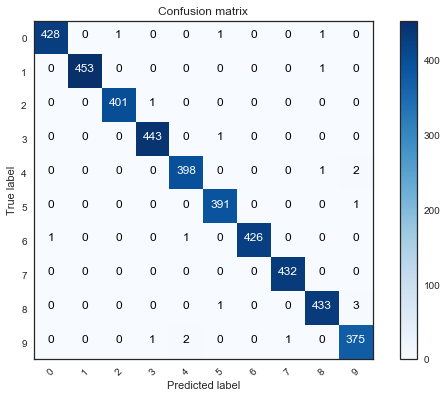

In [25]:
# Look at confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

In [26]:
confusion_mtx

array([[428,   0,   1,   0,   0,   1,   0,   0,   1,   0],
       [  0, 453,   0,   0,   0,   0,   0,   0,   1,   0],
       [  0,   0, 401,   1,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0, 443,   0,   1,   0,   0,   0,   0],
       [  0,   0,   0,   0, 398,   0,   0,   0,   1,   2],
       [  0,   0,   0,   0,   0, 391,   0,   0,   0,   1],
       [  1,   0,   0,   0,   1,   0, 426,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 432,   0,   0],
       [  0,   0,   0,   0,   0,   1,   0,   0, 433,   3],
       [  0,   0,   0,   1,   2,   0,   0,   1,   0, 375]])

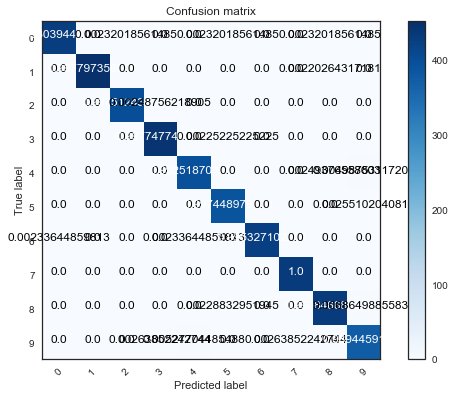

In [27]:
plot_confusion_matrix(confusion_mtx, classes = range(10), normalize=True)

[ 0.33586755  0.4297787   0.52963036  0.98859102  0.86103046  0.82922608
  0.50763029  0.62368107  0.91824222  0.95275265  0.59149116  0.52558136
  0.71625483  0.88942504  0.64963394  0.76973915  0.83964175  0.50668001
  0.8500365   0.40248895]


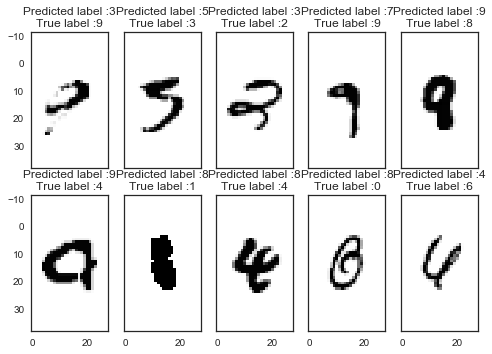

In [28]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index, img_errors, pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 5
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)
print(Y_pred_errors_prob)
# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 10 errors 
most_important_errors = sorted_dela_errors[-10:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

In [29]:
# predict results
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

In [30]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("output/cnn_mnist_datagen2.csv",index=False)